<a href="https://colab.research.google.com/github/bikram-sahu/Time-Series/blob/main/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)



import pandas as pd
series = np.array(pd.read_csv('nifty_close.csv')['value'])[:1400]
time = np.arange(len(series), dtype="float32")

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10
batch_size = 16
shuffle_buffer_size = 100

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
#for x,y in dataset:
#  print("x = ", x.numpy())
#  print("y = ", y.numpy())

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(dataset, epochs=500, callbacks=[earlystop])

Epoch 1/500
62/62 [==============================] - 0s 2ms/step - loss: 7358.1323 - mae: 7358.1323
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 7169.8501 - mae: 7169.8501
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 6981.5679 - mae: 6981.5679
Epoch 4/500
62/62 [==============================] - 0s 2ms/step - loss: 6793.2944 - mae: 6793.2944
Epoch 5/500
62/62 [==============================] - 0s 2ms/step - loss: 6605.0107 - mae: 6605.0107
Epoch 6/500
62/62 [==============================] - 0s 2ms/step - loss: 6416.7329 - mae: 6416.7329
Epoch 7/500
62/62 [==============================] - 0s 2ms/step - loss: 6228.4458 - mae: 6228.4458
Epoch 8/500
62/62 [==============================] - 0s 2ms/step - loss: 6040.1592 - mae: 6040.1592
Epoch 9/500
62/62 [==============================] - 0s 2ms/step - loss: 5851.8755 - mae: 5851.8755
Epoch 10/500
62/62 [==============================] - 0s 2ms/step - loss: 5663.5884 - mae: 5663.5884

In [ ]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.32805684],
       [-0.48596486],
       [ 0.27376127],
       [-0.3198572 ],
       [ 0.48019674],
       [-0.47886917],
       [ 0.86085194],
       [ 0.15584476],
       [-0.03267271],
       [ 0.21930479]], dtype=float32), array([2.4612606e-05], dtype=float32)]


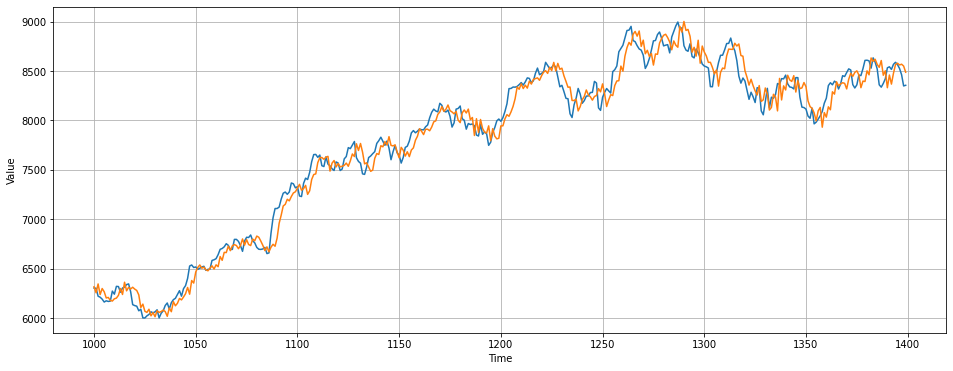

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(16, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

98.69926